In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
rootfolder = '.'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [4]:
def OMP(s, D, L, tau):
  omega = set()
  r = s
  N = D.shape[1]
  while len(omega) < L or np.linalg.norm(r) > tau:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        e[j] = np.linalg.norm(D[:, j] @ r)

    # find the column of D that matches at best r
    jStar = np.argmax(e)

    # UPDATE the support set with the jStar coefficient
    omega.add(jStar)

    _omega = list(omega)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x_OMP = np.linalg.inv(D[:, _omega].T @ D[:, _omega]) @ D[:, _omega].T @ s
    # update the residual
    r = s -  D[:, _omega] @ x_OMP

    x = np.zeros(N)
    x[list(omega)] = x_OMP.reshape(-1)

    return x

Load the image and rescale it in $[0,1]$

In [5]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Extract a bunch of random patches from the image

In [17]:
npatch = 10000

S = np.zeros((M, npatch))
for idx in range(npatch):
    i = np.random.randint(0, imsz[0] - p)
    j = np.random.randint(0, imsz[1] - p)
    S[:, idx] = img[i:i + p, j:j + p].reshape(-1)

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [18]:
S = S - S.mean(axis=0)

Initialize the dictionary and the coefficient matrix

In [19]:
# number of columns of the dictionary
N = 256

# intialize the dictionary
D = np.random.randn(M, N)

# normalize each column of D (zero mean and unit norm)
# UPDATE D
for j in range(N):
    D[:, j] = D[:, j] - D[:, j].mean()
    D[:, j] = D[:, j] / np.linalg.norm(D[:, j])

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))


Main KSVD loop


In [20]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
        X[:, n] = OMP(S[:, n], D, L, 1e-3)

    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.where(X[j, :] != 0)[0]

        if len(omega) == 0:
            continue
            # if the atom is never used then ignore or substitute it with a random vector
        else:
            # compute the residual matrix E, ignoring the j-th atom
            E = S
            for j0 in range(N):
                if(j0 != j):
                    E = E - D[:, j0].reshape(-1 ,1) @ X[j0, :].reshape(1, -1)

            # restrict E to the columns indicated by omega
            Eomega = E[:, omega]

            # compute the SVD of Eomega
            U, Sigma, V = np.linalg.svd(Eomega)

            # update the dictionary
            D[:, j] = U[:, 0]

            # update the coefficient matrix
            X[j, omega] = Sigma[0] * V[0, :]

    time_end = time.time()
    print(f'{time_end - time_start:.0f}')


iter 0
92
iter 1
90
iter 2
90
iter 3
90
iter 4
90
iter 5
90
iter 6
90
iter 7
91
iter 8
90
iter 9
93


Show the learned dictionary

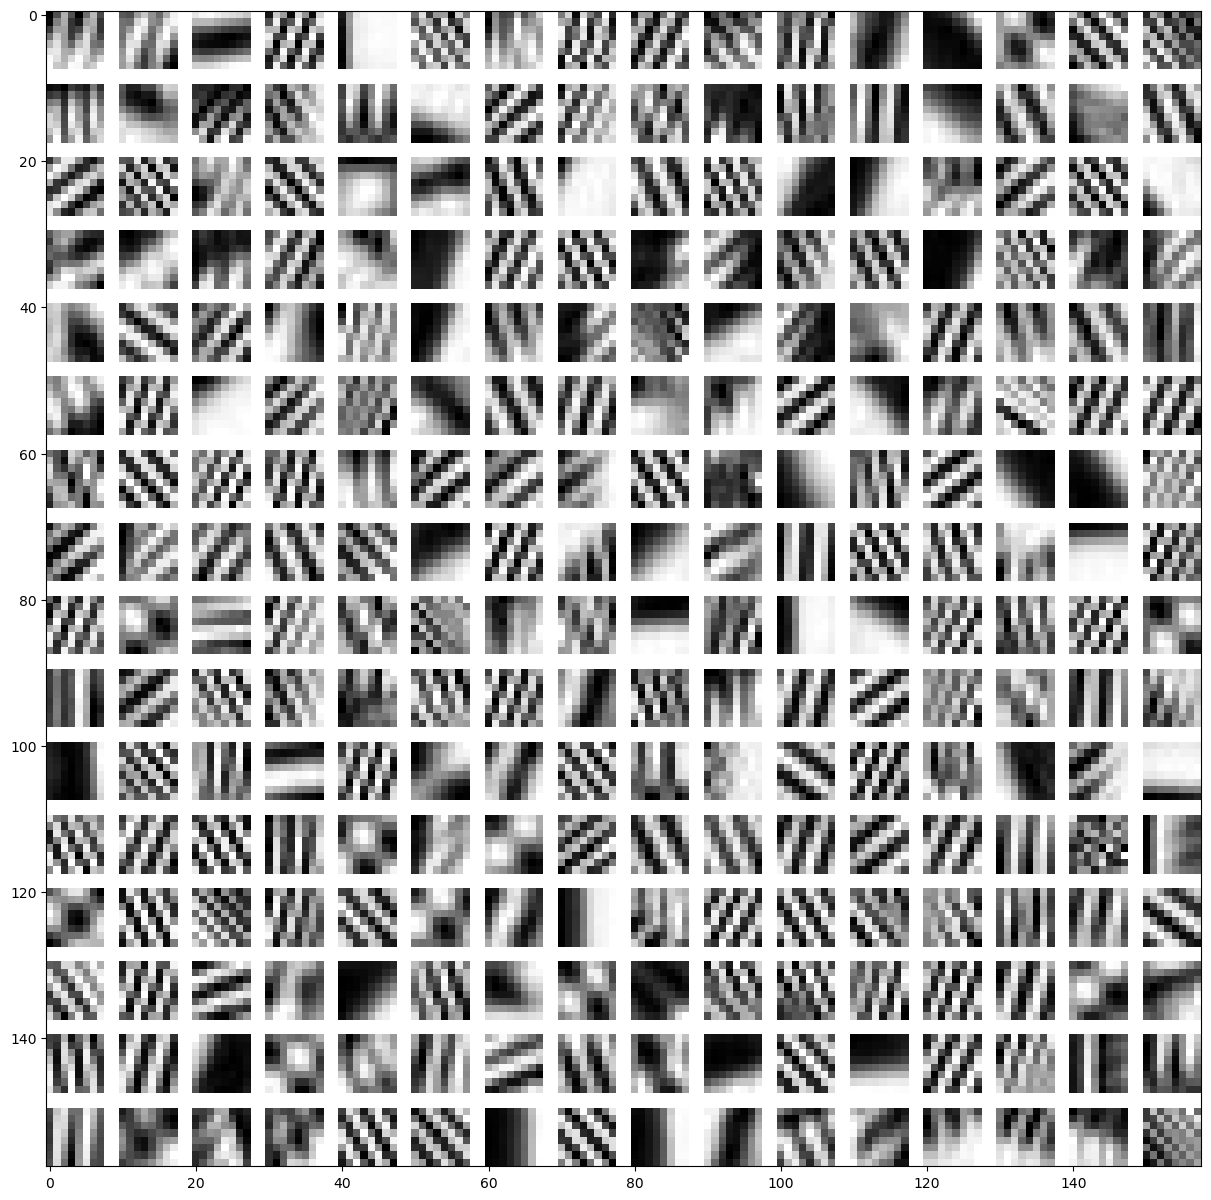

In [22]:
img_dict = get_dictionary_img(D)
plt.figure(figsize=(15, 15))
plt.imshow(img_dict, cmap='gray')
